## 데이터 가져오기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 74720505.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 모델 정의

In [2]:
import torch.nn as nn
import torch.nn.functional as F
class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.dropout = nn.Dropout(0.2)  # 마지막 완전 연결 레이어 전에 Dropout 추가
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)  # 완전 연결 레이어 전에 Dropout 적용
        out = self.linear(out)
        return out
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)
model = MobileNet().to(device)
model.apply(initialize_weights)
from torchsummary import summary
print("CNN's number of Parameters: ", sum([p.numel() for p in model.parameters()]))


summary(model,(3,32,32))

CNN's number of Parameters:  3217226
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]             288
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 64, 32, 32]           2,048
       BatchNorm2d-6           [-1, 64, 32, 32]             128
             Block-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 16, 16]             576
       BatchNorm2d-9           [-1, 64, 16, 16]             128
           Conv2d-10          [-1, 128, 16, 16]           8,192
      BatchNorm2d-11          [-1, 128, 16, 16]             256
            Block-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]           1,152
  

In [3]:
!pip install ptflops
from ptflops import get_model_complexity_info

macs, params = get_model_complexity_info(model, (3, 32, 32), as_strings=True,
                                          print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.7.1.2-py3-none-any.whl size=13213 sha256=883a82f27baaef4c61898cc93118cf71daea7ea726785358aa33883521e75a01
  Stored in directory: /root/.cache/pip/wheels/9d/90/07/20e8c3221349a85d63b319593e1bcbb6e0c995d2e2bcc5d775
Successfully built ptflops
Computational complexity:       47.59 MMac
Number of parameters:           3.22 M  


## 손실함수 정의

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 학습

In [ ]:
def model_train(epoch):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device),data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 6400==0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

## 검증 및 평가

In [ ]:
def model_evaluate():
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for data in testloader:
      images, labels = data[0].to(device),data[1].to(device)
      outputs = model(images)
      test_loss += F.cross_entropy(outputs, labels, reduction = "sum").item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_loss /= len(testloader.dataset)
  test_accuracy = 100. * correct / len(testloader.dataset)
  return test_loss,test_accuracy

In [ ]:
INPUT_EPOCHS = 50
losses = []
accuracies = []
for epoch in range(INPUT_EPOCHS):
  model_train(epoch)
  test_loss , test_accuracy = model_evaluate()
  losses.append(test_loss)
  accuracies.append(test_accuracy)
  print("[{}] Test Loss: {:.4f}, accuracy: {:.2f}%\n".format(epoch+1, test_loss, test_accuracy))

[1,     1] loss: 0.001
[1] Test Loss: 1.5811, accuracy: 41.68%

[2,     1] loss: 0.001
[2] Test Loss: 1.4172, accuracy: 48.16%

[3,     1] loss: 0.001
[3] Test Loss: 1.2414, accuracy: 55.91%

[4,     1] loss: 0.001
[4] Test Loss: 1.1663, accuracy: 58.09%

[5,     1] loss: 0.001
[5] Test Loss: 1.1097, accuracy: 61.47%

[6,     1] loss: 0.000
[6] Test Loss: 1.0206, accuracy: 64.55%

[7,     1] loss: 0.000
[7] Test Loss: 1.0149, accuracy: 65.04%

[8,     1] loss: 0.000
[8] Test Loss: 1.0112, accuracy: 66.31%

[9,     1] loss: 0.000
[9] Test Loss: 0.9485, accuracy: 67.97%

[10,     1] loss: 0.000
[10] Test Loss: 1.0601, accuracy: 67.19%

[11,     1] loss: 0.000
[11] Test Loss: 1.0428, accuracy: 68.51%

[12,     1] loss: 0.000
[12] Test Loss: 1.0797, accuracy: 68.90%

[13,     1] loss: 0.000
[13] Test Loss: 1.0813, accuracy: 68.15%

[14,     1] loss: 0.000
[14] Test Loss: 1.1725, accuracy: 69.18%

[15,     1] loss: 0.000
[15] Test Loss: 1.1001, accuracy: 69.72%

[16,     1] loss: 0.000
[16]

## 그래프 그리기

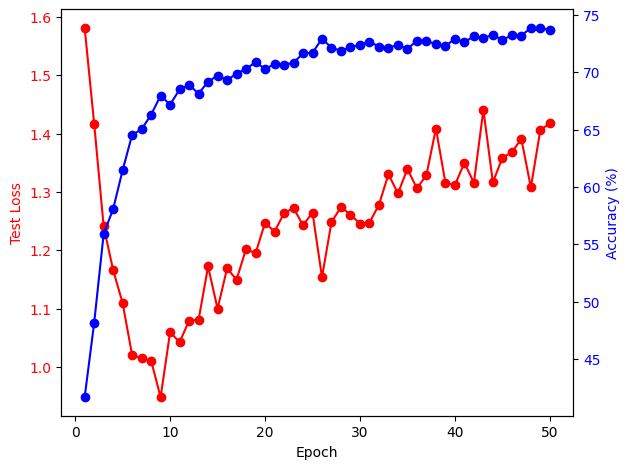

In [ ]:

import matplotlib.pyplot as plt
def draw_graph(losses,accuracies,x):
  x_epochs = range(1, x + 1)
  # 그래프 생성
  fig, ax1 = plt.subplots()

  # 첫 번째 Y축 (losses)
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Test Loss', color='red')
  ax1.plot(x_epochs, losses, 'r-o')
  ax1.tick_params(axis='y', labelcolor='red')

  # 두 번째 Y축 (accuracies)
  ax2 = ax1.twinx()  # 같은 X축을 공유하는 두 번째 Y축 생성
  ax2.set_ylabel('Accuracy (%)', color='blue')
  ax2.plot(x_epochs, accuracies, 'b-o')
  ax2.tick_params(axis='y', labelcolor='blue')

  # 그래프 표시
  fig.tight_layout()
  plt.show()
draw_graph(losses,accuracies,INPUT_EPOCHS)

In [ ]:
from torchsummary import summary
print("CNN's number of Parameters: ", sum([p.numel() for p in model.parameters()]))


summary(model,(3,32,32))

CNN's number of Parameters:  3217226
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]             288
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 64, 32, 32]           2,048
       BatchNorm2d-6           [-1, 64, 32, 32]             128
             Block-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 16, 16]             576
       BatchNorm2d-9           [-1, 64, 16, 16]             128
           Conv2d-10          [-1, 128, 16, 16]           8,192
      BatchNorm2d-11          [-1, 128, 16, 16]             256
            Block-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]           1,152
  